# Common Group Themes of Perfume

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [32]:
# Load cleaned perfume notes
cleaned_notes_path = "../data/cleaned_perfume_notes.txt"
with open(cleaned_notes_path, "r", encoding="utf-8") as f:
    valid_notes = set(f.read().splitlines())

# Load dataset
df = pd.read_csv("../data/raw/final_perfume_data.csv", encoding="ISO-8859-1")

In [33]:
print(df.info)
df.head()

<bound method DataFrame.info of                                      Name                   Brand  \
0                    Tihota Eau de Parfum                  Indult   
1                             Sola Parfum                  Di Ser   
2                          Kagiroi Parfum                  Di Ser   
3            Velvet Fantasy Eau de Parfum                 Montale   
4     A Blvd. Called Sunset Eau de Parfum           A Lab on Fire   
...                                   ...                     ...   
2186           Perfect Veil Eau de Parfum  Sarah Horowitz Parfums   
2187                  Scent Eau de Parfum        Costume National   
2188                 Bronze Eau de Parfum              Nanadebary   
2189         Monyette Paris Fragrance Oil          Monyette Paris   
2190                   1270 Eau de Parfum                  Frapin   

                                            Description  \
0      Rapa Nui for sugar, Tihota is, quite simply, ...   
1      A tribute to t

,Name,Brand,Description,Notes,Image URL
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, ...","Vanilla bean, musks",https://static.luckyscent.com/images/products/...
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending f...,"Lavender, Yuzu, Lemongrass, Magnolia, Geraniu...",https://static.luckyscent.com/images/products/...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japa...,"Green yuzu, green shikuwasa, sansho seed, cor...",https://static.luckyscent.com/images/products/...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where cit...,"tangerine, pink pepper, black coffee, leat...",https://static.luckyscent.com/images/products/...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate t...,"Bergamot, almond, violet, jasmine, leather, s...",https://static.luckyscent.com/images/products/...


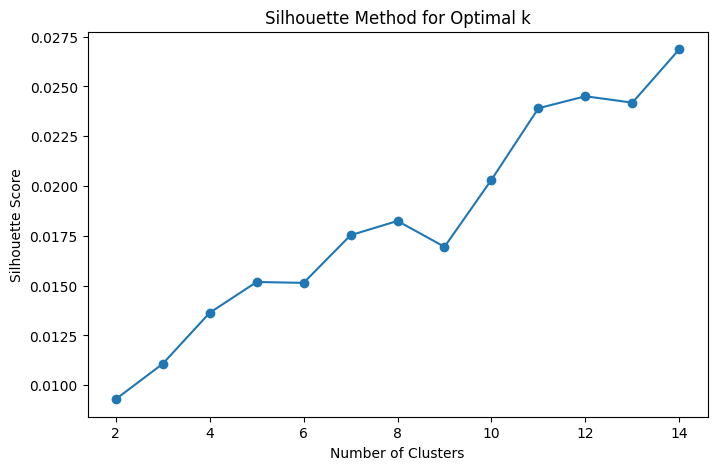

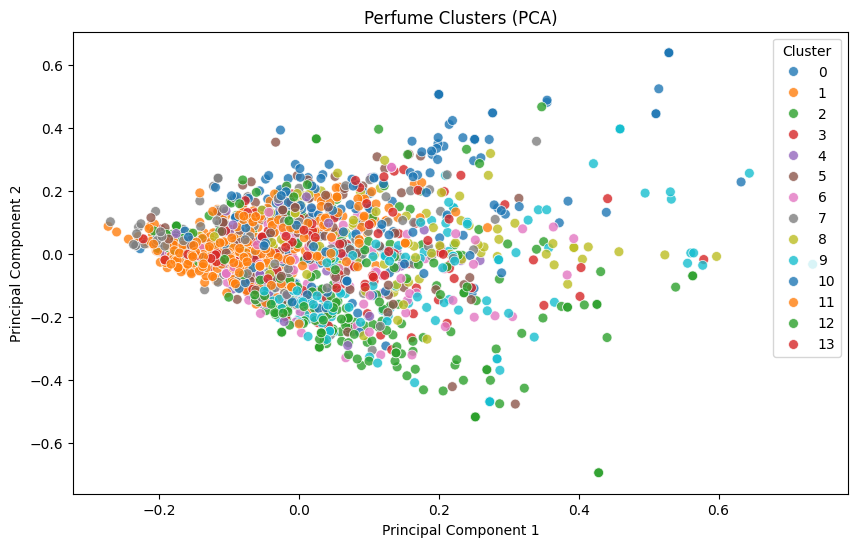

Recommendations for 'Oud Dream Eau de Parfum':
                               Name  Similarity
1438    Blue Sapphire Eau de Parfum    0.594617
850     Fantastic Oud Eau de Parfum    0.510618
1287  African Leather Eau de Parfum    0.503998
1151      Incense Oud Eau de Parfum    0.495907
1336   Wild Rose Aoud Eau de Parfum    0.492409


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Load cleaned perfume notes
cleaned_notes_path = "../data/cleaned_perfume_notes.txt"
with open(cleaned_notes_path, "r", encoding="utf-8") as f:
    valid_notes = set(f.read().splitlines())

# Load dataset
df = pd.read_csv("../data/raw/final_perfume_data.csv", encoding="ISO-8859-1")

# Drop unnecessary columns
df.drop(columns=['Image URL', 'Description'], inplace=True, errors='ignore')

# Drop NaN values in 'Notes' column
df.dropna(subset=['Notes'], inplace=True)

# Reset index to ensure proper alignment
df.reset_index(drop=True, inplace=True)

# Filter and clean notes
df['Notes'] = df['Notes'].apply(lambda x: ', '.join([note for note in x.split(', ') if note in valid_notes]))

# Remove empty notes after filtering
df = df[df['Notes'].str.strip() != '']
df.reset_index(drop=True, inplace=True)

# Apply TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_notes = vectorizer.fit_transform(df['Notes'])

# Convert sparse matrix to NumPy array for similarity calculations
X_notes_array = X_notes.toarray()

# Find the optimal number of clusters using the Silhouette Method
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_notes)
    score = silhouette_score(X_notes, labels)
    silhouette_scores.append(score)

# Plot Silhouette Score for optimal k
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()

# Choose the best k based on the silhouette score
num_clusters = k_range[np.argmax(silhouette_scores)]  # Best k

# Train KMeans clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(X_notes)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_notes_array)

df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = df['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue=df_plot['Cluster'], palette='tab10', s=50, alpha=0.8)
plt.title("Perfume Clusters (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Perfume Recommendation Function
def recommend_perfumes(perfume_name, num_recommendations=5):
    if perfume_name not in df['Name'].values:
        return f"Perfume '{perfume_name}' not found in the dataset."

    # Find the index of the given perfume
    idx = df[df['Name'] == perfume_name].index[0]  

    # Get the cluster of the given perfume
    cluster = df.loc[idx, 'Cluster']

    # Get all perfumes in the same cluster (excluding the input perfume)
    cluster_members = df[df['Cluster'] == cluster].copy()
    cluster_members = cluster_members[cluster_members['Name'] != perfume_name]

    if cluster_members.empty:
        return f"No similar perfumes found in the same cluster as '{perfume_name}'."

    # Convert DataFrame indices to integer positions for X_notes_array
    cluster_indices = cluster_members.index.tolist()

    # Ensure valid indices to avoid IndexError
    if idx >= X_notes_array.shape[0] or max(cluster_indices) >= X_notes_array.shape[0]:
        return "Error: Index out of bounds. Please check dataset consistency."

    # Compute cosine similarity between the selected perfume and all in the same cluster
    similarity_scores = cosine_similarity(X_notes_array[idx].reshape(1, -1), X_notes_array[cluster_indices]).flatten()

    # Assign similarity scores to cluster members
    cluster_members = cluster_members.assign(Similarity=similarity_scores)

    # Sort by similarity and return top recommendations
    recommendations = cluster_members.sort_values(by='Similarity', ascending=False).head(num_recommendations)

    return recommendations[['Name', 'Similarity']]

# Example usage
perfume_name = "Oud Dream Eau de Parfum"
recommendations = recommend_perfumes(perfume_name)
print(f"Recommendations for '{perfume_name}':")
print(recommendations)
